In [1]:
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import WindowFeatures

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
import shap
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    FunctionTransformer,
    PolynomialFeatures,
)
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

import skforecast
from skforecast.recursive import ForecasterEquivalentDate, ForecasterRecursive
from skforecast.model_selection import (
    TimeSeriesFold,
    OneStepAheadFold,
    bayesian_search_forecaster,
    backtesting_forecaster,
)
from skforecast.preprocessing import RollingFeatures
from skforecast.feature_selection import select_features
from skforecast.metrics import calculate_coverage

# Warnings configuration
# ==============================================================================
import warnings

In [2]:
data = fetch_dataset('bike_sharing', raw=True)

bike_sharing
------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, information
about weather conditions and holidays is available.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17544, 12)


# Preprocessing data (setting index and frequency)

In [3]:
data = data[['date_time', 'users', 'holiday', 'weather', 'temp', 'atemp', 'hum', 'windspeed']]
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
if pd.__version__ < '2.2':
    data = data.asfreq('H')
else:
    data = data.asfreq('h')
data = data.sort_index()
data.head()

users  holiday weather  temp   atemp   hum  windspeed
date_time                                                                 
2011-01-01 00:00:00   16.0      0.0   clear  9.84  14.395  81.0        0.0
2011-01-01 01:00:00   40.0      0.0   clear  9.02  13.635  80.0        0.0
2011-01-01 02:00:00   32.0      0.0   clear  9.02  13.635  80.0        0.0
2011-01-01 03:00:00   13.0      0.0   clear  9.84  14.395  75.0        0.0
2011-01-01 04:00:00    1.0      0.0   clear  9.84  14.395  75.0        0.0

# Split train-validation-test

In [4]:

end_train = '2012-04-30 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-01-01 00:00:00 --- 2012-04-30 23:00:00  (n=11664)
Dates validacion : 2012-05-01 00:00:00 --- 2012-08-31 23:00:00  (n=2952)
Dates test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


# Interactive plot of time series

In [5]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['users'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['users'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['users'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Number of users',
    xaxis_title="Time",
    yaxis_title="Users",
    legend_title="Partition:",
    width=1200,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1, xanchor="left", x=0.001)
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

# Static plot of time series with zoom

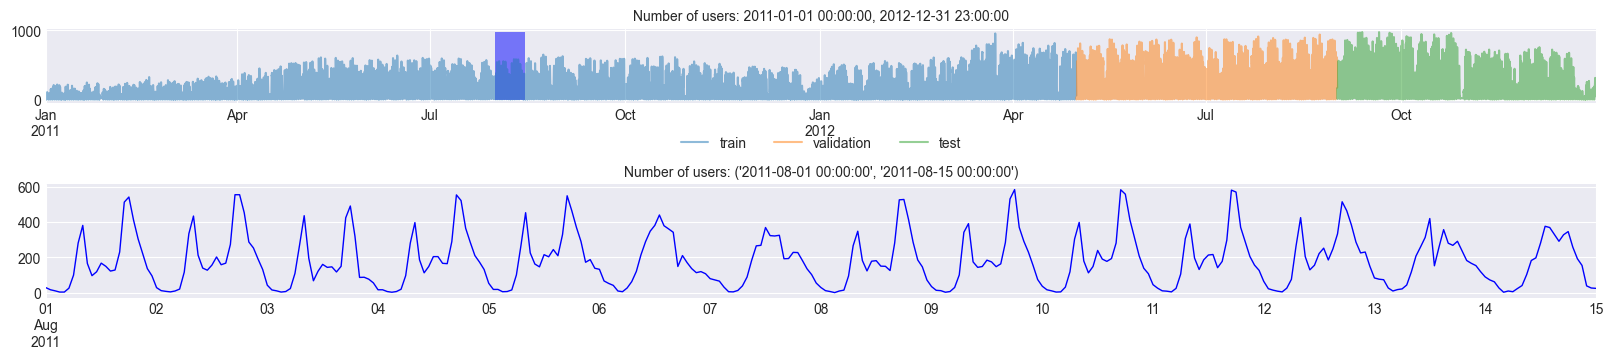

In [6]:
zoom = ('2011-08-01 00:00:00', '2011-08-15 00:00:00')
fig = plt.figure(figsize=(20, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.1, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])

data_train['users'].plot(ax=main_ax, label='train', alpha=0.5)
data_val['users'].plot(ax=main_ax, label='validation', alpha=0.5)
data_test['users'].plot(ax=main_ax, label='test', alpha=0.5)
min_y = min(data['users'])
max_y = max(data['users'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_title(f'Number of users: {data.index.min()}, {data.index.max()}', fontsize=10)
main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))
zoom_ax = fig.add_subplot(grid[5:, :])
data.loc[zoom[0]: zoom[1]]['users'].plot(ax=zoom_ax, color='blue', linewidth=1)
zoom_ax.set_title(f'Number of users: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)
plt.show();

# Seasonality plots

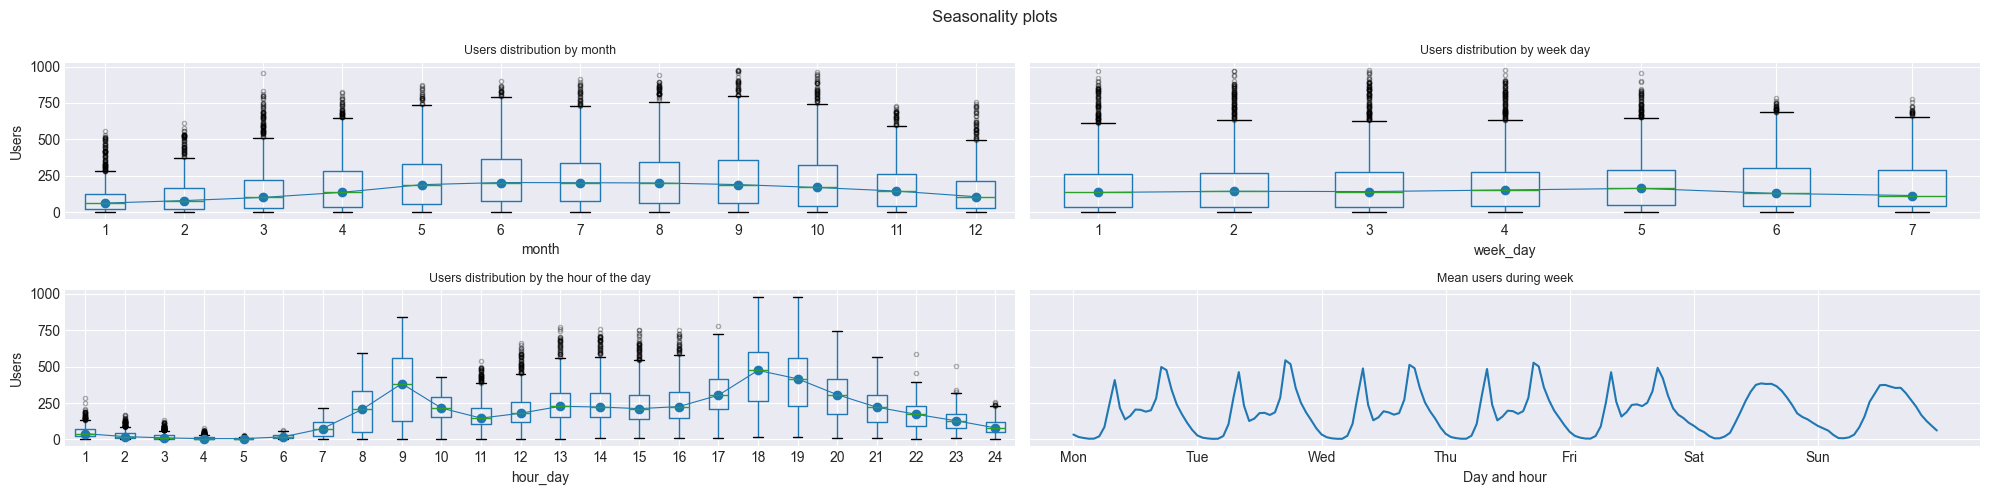

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(20, 5), sharex=False, sharey=True)
axs = axs.ravel()

# Users distribution by month
data['month'] = data.index.month
data.boxplot(column='users', by='month', ax=axs[0], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('month')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('Users')
axs[0].set_title('Users distribution by month', fontsize=9)

# Users distribution by week day
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='users', by='week_day', ax=axs[1], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('week_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('Users')
axs[1].set_title('Users distribution by week day', fontsize=9)

# Users distribution by the hour of the day
data['hour_day'] = data.index.hour + 1
data.boxplot(column='users', by='hour_day', ax=axs[2], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('hour_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('Users')
axs[2].set_title('Users distribution by the hour of the day', fontsize=9)

# Users distribution by week day and hour of the day
mean_day_hour = data.groupby(["week_day", "hour_day"])["users"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Mean users during week",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel      = "Day and hour",
    ylabel      = "Number of users"
)
axs[3].title.set_size(9)

fig.suptitle("Seasonality plots", fontsize=12)
fig.tight_layout()

# Create baseline: value of the same hour of the previous day

In [8]:
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(days=1),
                 n_offsets = 1
             )

forecaster.fit(y=data.loc[:end_validation, 'users'])
forecaster

ForecasterEquivalentDate 
Offset: <DateOffset: days=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 24 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Creation date: 2025-04-07 09:46:11 
Last fit date: 2025-04-07 09:46:11 
Skforecast version: 0.15.1 
Python version: 3.10.16 
Forecaster id: None 

In [9]:
cv = TimeSeriesFold(steps = 36, initial_train_size = len(data.loc[:end_validation]))
metric_baseline, predictions = backtesting_forecaster(
                                   forecaster = forecaster,
                                   y          = data['users'],
                                   cv         = cv,
                                   metric     = 'mean_absolute_error'
                               )

  0%|          | 0/82 [00:00<?, ?it/s]

In [10]:
metric_baseline

mean_absolute_error
0            91.668716

# LightGBM

![Alt text](../data/images/recursive_forecasting.gif)


![Alt text](../data/images/matrix_transformation_with_exog_variable.png)

**LightGBM** is a highly efficient implementation of the stochastic gradient boosting algorithm and is considered a benchmark in modern machine learning.
- It offers both a native API and a scikit-learn-compatible API, making it fully compatible with libraries like **Skforecast**.

- The modeling process includes:
  - Training a `ForecasterRecursive` model using past values (lags) and moving averages as predictors.
  - Incorporating **exogenous variables** into the model to evaluate the improvement in forecasting performance.
  - Performing **Bayesian hyperparameter optimization** using `bayesian_search_forecaster()` to tune both model hyperparameters and lag structure.
  - Assessing the model’s predictive ability through a **backtesting** process to simulate performance on unseen data.


In [11]:
window_features = RollingFeatures(stats=["mean"], window_sizes=24 * 3)
forecaster = ForecasterRecursive(
                regressor       = LGBMRegressor(random_state=15926, verbose=-1),
                lags            = 24,
                window_features = window_features
             )

forecaster.fit(y=data.loc[:end_validation, 'users'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_72'] 
Window size: 72 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample':
    1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-04-07 10:03:20 
Last fit date: 2025-04-07 10:03:20 
Skforecast version: 0.15.1 
Python version: 3.10.16 
Forecaster id: None

In [12]:
window_features

RollingFeatures(
    stats           = ['mean'],
    window_sizes    = [72],
    Max window size = 72,
    min_periods     = [72],
    features_names  = ['roll_mean_72'],
    fillna          = None
    kwargs_stats    = {'ewm': {'alpha': 0.3}},
)

In [13]:
forecaster.predict(steps=10)

2012-09-01 00:00:00    108.331027
2012-09-01 01:00:00     68.562982
2012-09-01 02:00:00     33.499525
2012-09-01 03:00:00     10.027583
2012-09-01 04:00:00      3.037563
2012-09-01 05:00:00     17.162543
2012-09-01 06:00:00     51.059825
2012-09-01 07:00:00    146.940053
2012-09-01 08:00:00    344.320596
2012-09-01 09:00:00    439.738683
Freq: h, Name: pred, dtype: float64

# Backtesting

![Alt text](../data/images/backtesting_no_refit.gif)


In [14]:
cv = TimeSeriesFold(steps = 36, initial_train_size = len(data.loc[:end_validation]))
metric, predictions = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = data['users'],
                          cv         = cv,
                          metric     = 'mean_absolute_error'
                      )
predictions.head()

  0%|          | 0/82 [00:00<?, ?it/s]

pred
2012-09-01 00:00:00  108.331027
2012-09-01 01:00:00   68.562982
2012-09-01 02:00:00   33.499525
2012-09-01 03:00:00   10.027583
2012-09-01 04:00:00    3.037563


You use your **historical data** to test how well the model can predict future values.

- The idea is to pretend you're at a certain point in time (e.g., January 1st), and:
  - Use only the data available **up to that day**
  - Ask the model to **predict the next few days**
  - Compare those predictions to the **actual values** that happened

- Then you move forward one step in time (e.g., to January 2nd) and repeat the process.
- This is done again and again, always using past data only — just like you would in a real production setup.
- The process gives you a realistic picture of how well the model performs over time, not just on a fixed test set.
- In `skforecast`, the `backtesting_forecaster()` function automates this step-by-step simulation for you.


In [15]:
metric

mean_absolute_error
0            76.464247

In [16]:
X_train, y_train = forecaster.create_train_X_y(
    y = data.loc[:end_validation, 'users'],
    exog = None
)

In [18]:
X_train[:3]

lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  \
date_time                                                                     
2011-01-04 00:00:00   12.0   20.0   52.0   52.0  110.0  157.0  157.0   76.0   
2011-01-04 01:00:00    5.0   12.0   20.0   52.0   52.0  110.0  157.0  157.0   
2011-01-04 02:00:00    2.0    5.0   12.0   20.0   52.0   52.0  110.0  157.0   

                     lag_9  lag_10  ...  lag_16  lag_17  lag_18  lag_19  \
date_time                           ...                                   
2011-01-04 00:00:00   72.0    77.0  ...   154.0    64.0    30.0     3.0   
2011-01-04 01:00:00   76.0    72.0  ...    88.0   154.0    64.0    30.0   
2011-01-04 02:00:00  157.0    76.0  ...    44.0    88.0   154.0    64.0   

                     lag_20  lag_21  lag_22  lag_23  lag_24  roll_mean_72  
date_time                                                                  
2011-01-04 00:00:00     1.0     2.0     2.0     2.0     5.0     43.638889  
2011-01-04 01:00:00     3.0     1.0     2.0     2.0     2.0     43.486111  
2011-01-04 02:00:00    30.0     3.0     1.0     2.0     2.0     42.958333  

[3 rows x 25 columns]

In [19]:
y_train[:3]

date_time
2011-01-04 00:00:00    5.0
2011-01-04 01:00:00    2.0
2011-01-04 02:00:00    1.0
Freq: h, Name: y, dtype: float64

In [17]:
[X_train[:3], y_train[:3]]

[                     lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  \
 date_time                                                                     
 2011-01-04 00:00:00   12.0   20.0   52.0   52.0  110.0  157.0  157.0   76.0   
 2011-01-04 01:00:00    5.0   12.0   20.0   52.0   52.0  110.0  157.0  157.0   
 2011-01-04 02:00:00    2.0    5.0   12.0   20.0   52.0   52.0  110.0  157.0   
 
                      lag_9  lag_10  ...  lag_16  lag_17  lag_18  lag_19  \
 date_time                           ...                                   
 2011-01-04 00:00:00   72.0    77.0  ...   154.0    64.0    30.0     3.0   
 2011-01-04 01:00:00   76.0    72.0  ...    88.0   154.0    64.0    30.0   
 2011-01-04 02:00:00  157.0    76.0  ...    44.0    88.0   154.0    64.0   
 
                      lag_20  lag_21  lag_22  lag_23  lag_24  roll_mean_72  
 date_time                                                                  
 2011-01-04 00:00:00     1.0     2.0     2.0     2.0     5.0  

# Using Exogenous Variables in Time Series Forecasting

So far, we've only used **lagged values** of the time series as predictors. However, we can also include **external variables** to improve the model's performance. These are known as **exogenous variables** (or features), and they can help capture patterns not present in the series itself.

> **Important:** The values of exogenous variables must be **known at the time of prediction**.  
> If the values are not available for the future, the model cannot make reliable forecasts.

---

### Common Examples of Exogenous Variables

- **Calendar-based features:**
  - Day of the week
  - Month
  - Year
  - Holidays

- **Weather-related features:**
  - Temperature
  - Humidity
  - Wind

- **Economic indicators:**
  - Inflation
  - Interest rates

---

### Using Weather Data with Caution

- Weather is often used as an exogenous variable, but **future weather values are not known** — they're **predictions made by meteorological services**.
- These predictions can introduce errors into your model and reduce its accuracy.
- A good practice is to train your model using **forecasted weather data** (not actual recorded data) so that you can better estimate real-world performance.

---

### What's Next?

We'll now create exogenous variables based on:

- **Calendar information**
- **Sunrise and sunset times**
- **Temperature data**
- **Holiday indicators**

These features will be added to the training, validation, and test sets, and used as additional predictors in our **autoregressive model**.


## Calendar features

In [20]:
features_to_extract = [
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables           ='index',
    features_to_extract = features_to_extract,
    drop_original       = True,
)
calendar_features = calendar_transformer.fit_transform(data)[features_to_extract]

In [21]:
calendar_features

month  week  day_of_week  hour
date_time                                          
2011-01-01 00:00:00      1    52            5     0
2011-01-01 01:00:00      1    52            5     1
2011-01-01 02:00:00      1    52            5     2
2011-01-01 03:00:00      1    52            5     3
2011-01-01 04:00:00      1    52            5     4
...                    ...   ...          ...   ...
2012-12-31 19:00:00     12     1            0    19
2012-12-31 20:00:00     12     1            0    20
2012-12-31 21:00:00     12     1            0    21
2012-12-31 22:00:00     12     1            0    22
2012-12-31 23:00:00     12     1            0    23

[17544 rows x 4 columns]

## Sunlight features

In [22]:
location = LocationInfo(
    name      = 'Washington DC',
    region    = 'USA',
    timezone  = 'US/Eastern',
    latitude  = 40.516666666666666,
    longitude = -77.03333333333333
)
sunrise_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunrise'].hour
    for date in data.index
]
sunset_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunset'].hour
    for date in data.index
]
sun_light_features = pd.DataFrame({
                        'sunrise_hour': sunrise_hour,
                        'sunset_hour': sunset_hour}, 
                        index = data.index
                     )
sun_light_features['daylight_hours'] = (
    sun_light_features['sunset_hour'] - sun_light_features['sunrise_hour']
)
sun_light_features["is_daylight"] = np.where(
    (data.index.hour >= sun_light_features["sunrise_hour"])
    & (data.index.hour < sun_light_features["sunset_hour"]),
    1,
    0,
)

In [24]:
sun_light_features[10:24]

sunrise_hour  sunset_hour  daylight_hours  is_daylight
date_time                                                                  
2011-01-01 10:00:00             7           16               9            1
2011-01-01 11:00:00             7           16               9            1
2011-01-01 12:00:00             7           16               9            1
2011-01-01 13:00:00             7           16               9            1
2011-01-01 14:00:00             7           16               9            1
2011-01-01 15:00:00             7           16               9            1
2011-01-01 16:00:00             7           16               9            0
2011-01-01 17:00:00             7           16               9            0
2011-01-01 18:00:00             7           16               9            0
2011-01-01 19:00:00             7           16               9            0
2011-01-01 20:00:00             7           16               9            0
2011-01-01 21:00:00             7           16               9            0
2011-01-01 22:00:00             7           16               9            0
2011-01-01 23:00:00             7           16               9            0

## Holiday features

In [25]:
holiday_features = data[['holiday']].astype(int)
holiday_features['holiday_previous_day'] = holiday_features['holiday'].shift(24)
holiday_features['holiday_next_day'] = holiday_features['holiday'].shift(-24)

In [26]:
holiday_features

holiday  holiday_previous_day  holiday_next_day
date_time                                                           
2011-01-01 00:00:00        0                   NaN               0.0
2011-01-01 01:00:00        0                   NaN               0.0
2011-01-01 02:00:00        0                   NaN               0.0
2011-01-01 03:00:00        0                   NaN               0.0
2011-01-01 04:00:00        0                   NaN               0.0
...                      ...                   ...               ...
2012-12-31 19:00:00        0                   0.0               NaN
2012-12-31 20:00:00        0                   0.0               NaN
2012-12-31 21:00:00        0                   0.0               NaN
2012-12-31 22:00:00        0                   0.0               NaN
2012-12-31 23:00:00        0                   0.0               NaN

[17544 rows x 3 columns]

# Rolling windows of temperature

In [27]:
wf_transformer = WindowFeatures(
    variables   = ["temp"],
    window      = ["1D", "7D"],
    functions   = ["mean", "max", "min"],
    freq        = "h",
)
temp_features = wf_transformer.fit_transform(data[['temp']])

# Merge all exogenous variables

In [29]:
assert all(calendar_features.index == sun_light_features.index)
assert all(calendar_features.index == temp_features.index)
assert all(calendar_features.index == holiday_features.index)

df_exogenous_features = pd.concat([
    calendar_features,
    sun_light_features,
    temp_features,
    holiday_features
], axis=1)

# Due to the creation of moving averages, there are missing values at the beginning
# of the series. And due to holiday_next_day there are missing values at the end.
df_exogenous_features = df_exogenous_features.iloc[7 * 24:, :]
df_exogenous_features = df_exogenous_features.iloc[:-24, :]
df_exogenous_features.head(3)

month  week  day_of_week  hour  sunrise_hour  \
date_time                                                           
2011-01-08 00:00:00      1     1            5     0             7   
2011-01-08 01:00:00      1     1            5     1             7   
2011-01-08 02:00:00      1     1            5     2             7   

                     sunset_hour  daylight_hours  is_daylight  temp  \
date_time                                                             
2011-01-08 00:00:00           16               9            0  7.38   
2011-01-08 01:00:00           16               9            0  7.38   
2011-01-08 02:00:00           16               9            0  7.38   

                     temp_window_1D_mean  temp_window_1D_max  \
date_time                                                      
2011-01-08 00:00:00             8.063333                9.02   
2011-01-08 01:00:00             8.029167                9.02   
2011-01-08 02:00:00             7.995000                9.02   

                     temp_window_1D_min  temp_window_7D_mean  \
date_time                                                      
2011-01-08 00:00:00                6.56            10.127976   
2011-01-08 01:00:00                6.56            10.113333   
2011-01-08 02:00:00                6.56            10.103571   

                     temp_window_7D_max  temp_window_7D_min  holiday  \
date_time                                                              
2011-01-08 00:00:00               18.86                4.92        0   
2011-01-08 01:00:00               18.86                4.92        0   
2011-01-08 02:00:00               18.86                4.92        0   

                     holiday_previous_day  holiday_next_day  
date_time                                                    
2011-01-08 00:00:00                   0.0               0.0  
2011-01-08 01:00:00                   0.0               0.0  
2011-01-08 02:00:00                   0.0               0.0

In [30]:
df_exogenous_features.tail(3)

month  week  day_of_week  hour  sunrise_hour  \
date_time                                                           
2012-12-30 21:00:00     12    52            6    21             7   
2012-12-30 22:00:00     12    52            6    22             7   
2012-12-30 23:00:00     12    52            6    23             7   

                     sunset_hour  daylight_hours  is_daylight  temp  \
date_time                                                             
2012-12-30 21:00:00           16               9            0   8.2   
2012-12-30 22:00:00           16               9            0   8.2   
2012-12-30 23:00:00           16               9            0   8.2   

                     temp_window_1D_mean  temp_window_1D_max  \
date_time                                                      
2012-12-30 21:00:00            10.830833               13.94   
2012-12-30 22:00:00            10.694167               13.94   
2012-12-30 23:00:00            10.591667               13.94   

                     temp_window_1D_min  temp_window_7D_mean  \
date_time                                                      
2012-12-30 21:00:00                9.02            10.455000   
2012-12-30 22:00:00                8.20            10.445238   
2012-12-30 23:00:00                8.20            10.435476   

                     temp_window_7D_max  temp_window_7D_min  holiday  \
date_time                                                              
2012-12-30 21:00:00                16.4                7.38        0   
2012-12-30 22:00:00                16.4                7.38        0   
2012-12-30 23:00:00                16.4                7.38        0   

                     holiday_previous_day  holiday_next_day  
date_time                                                    
2012-12-30 21:00:00                   0.0               0.0  
2012-12-30 22:00:00                   0.0               0.0  
2012-12-30 23:00:00                   0.0               0.0

## Handling Cyclical Features in Time Series

Some calendar-based features, such as the hour of the day or day of the week, follow a cyclical pattern. For example, the hour of the day ranges from 0 to 23 and then wraps around back to 0. It's important to represent these features in a way that reflects their cyclical nature.

### 1. Using raw numeric values

- Features are used as-is, e.g., hour = 0 to 23
- Simple to implement
- May impose an incorrect linear relationship
- Example: hour 23 and hour 0 are far apart numerically, but only one hour apart in reality

### 2. Treating cyclical features as categorical

- Each value is treated as a separate category
- Prevents false linear assumptions
- Loses information about the cyclical relationship between values
- Can increase the number of features significantly (e.g., through one-hot encoding)

### 3. Sine and cosine transformation (recommended)

- Transforms the cyclical feature using sine and cosine functions based on its period
- Preserves the cyclical structure and natural ordering
- Requires only two new features per cyclical variable
- Handles the wrap-around effect correctly

Example for hour of day (0–23):

```python
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)


In [31]:
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
    "sunrise_hour",
    "sunset_hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 7,
    "hour": 24,
    "sunrise_hour": 24,
    "sunset_hour": 24,
}
cyclical_encoder = CyclicalFeatures(
    variables     = features_to_encode,
    max_values    = max_values,
    drop_original = False
)

df_exogenous_features = cyclical_encoder.fit_transform(df_exogenous_features)
df_exogenous_features.head(3)

month  week  day_of_week  hour  sunrise_hour  \
date_time                                                           
2011-01-08 00:00:00      1     1            5     0             7   
2011-01-08 01:00:00      1     1            5     1             7   
2011-01-08 02:00:00      1     1            5     2             7   

                     sunset_hour  daylight_hours  is_daylight  temp  \
date_time                                                             
2011-01-08 00:00:00           16               9            0  7.38   
2011-01-08 01:00:00           16               9            0  7.38   
2011-01-08 02:00:00           16               9            0  7.38   

                     temp_window_1D_mean  ...  week_sin  week_cos  \
date_time                                 ...                       
2011-01-08 00:00:00             8.063333  ...  0.120537  0.992709   
2011-01-08 01:00:00             8.029167  ...  0.120537  0.992709   
2011-01-08 02:00:00             7.995000  ...  0.120537  0.992709   

                     day_of_week_sin  day_of_week_cos  hour_sin  hour_cos  \
date_time                                                                   
2011-01-08 00:00:00        -0.974928        -0.222521  0.000000  1.000000   
2011-01-08 01:00:00        -0.974928        -0.222521  0.258819  0.965926   
2011-01-08 02:00:00        -0.974928        -0.222521  0.500000  0.866025   

                     sunrise_hour_sin  sunrise_hour_cos  sunset_hour_sin  \
date_time                                                                  
2011-01-08 00:00:00          0.965926         -0.258819        -0.866025   
2011-01-08 01:00:00          0.965926         -0.258819        -0.866025   
2011-01-08 02:00:00          0.965926         -0.258819        -0.866025   

                     sunset_hour_cos  
date_time                             
2011-01-08 00:00:00             -0.5  
2011-01-08 01:00:00             -0.5  
2011-01-08 02:00:00             -0.5  

[3 rows x 30 columns]

# Feature interaction

Exogenous variables often do not act independently. Their effect on the target variable can depend on the values of other variables.

For example:
- The impact of temperature on electricity demand may vary depending on the time of day.
- High temperatures might increase demand in the afternoon (due to air conditioning), but have little effect at night.

To model these kinds of relationships, we can create **interaction features**. These are new features generated by multiplying two or more existing variables together.

This allows the model to capture more complex dependencies between variables.

# Creating Interaction Features

Interaction features can be created manually or using tools like `PolynomialFeatures` from `scikit-learn`.

Example using `PolynomialFeatures`:

```python
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_features = poly.fit_transform(df[['temperature', 'hour']])


In [32]:
transformer_poly = PolynomialFeatures(
                        degree           = 2,
                        interaction_only = True,
                        include_bias     = False
                    ).set_output(transform="pandas")
poly_cols = [
    'month_sin', 
    'month_cos',
    'week_sin',
    'week_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'hour_sin',
    'hour_cos',
    'sunrise_hour_sin',
    'sunrise_hour_cos',
    'sunset_hour_sin',
    'sunset_hour_cos',
    'daylight_hours',
    'is_daylight',
    'holiday_previous_day',
    'holiday_next_day',
    'temp_window_1D_mean',
    'temp_window_1D_min',
    'temp_window_1D_max',
    'temp_window_7D_mean',
    'temp_window_7D_min',
    'temp_window_7D_max',
    'temp',
    'holiday'
]

poly_features = transformer_poly.fit_transform(df_exogenous_features[poly_cols])
poly_features = poly_features.drop(columns=poly_cols)
poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
poly_features.columns = poly_features.columns.str.replace(" ", "__")
assert all(poly_features.index == df_exogenous_features.index)
df_exogenous_features = pd.concat([df_exogenous_features, poly_features], axis=1)
df_exogenous_features.head(3)

month  week  day_of_week  hour  sunrise_hour  \
date_time                                                           
2011-01-08 00:00:00      1     1            5     0             7   
2011-01-08 01:00:00      1     1            5     1             7   
2011-01-08 02:00:00      1     1            5     2             7   

                     sunset_hour  daylight_hours  is_daylight  temp  \
date_time                                                             
2011-01-08 00:00:00           16               9            0  7.38   
2011-01-08 01:00:00           16               9            0  7.38   
2011-01-08 02:00:00           16               9            0  7.38   

                     temp_window_1D_mean  ...  \
date_time                                 ...   
2011-01-08 00:00:00             8.063333  ...   
2011-01-08 01:00:00             8.029167  ...   
2011-01-08 02:00:00             7.995000  ...   

                     poly_temp_window_7D_mean__temp_window_7D_min  \
date_time                                                           
2011-01-08 00:00:00                                     49.829643   
2011-01-08 01:00:00                                     49.757600   
2011-01-08 02:00:00                                     49.709571   

                     poly_temp_window_7D_mean__temp_window_7D_max  \
date_time                                                           
2011-01-08 00:00:00                                    191.013631   
2011-01-08 01:00:00                                    190.737467   
2011-01-08 02:00:00                                    190.553357   

                     poly_temp_window_7D_mean__temp  \
date_time                                             
2011-01-08 00:00:00                       74.744464   
2011-01-08 01:00:00                       74.636400   
2011-01-08 02:00:00                       74.564357   

                     poly_temp_window_7D_mean__holiday  \
date_time                                                
2011-01-08 00:00:00                                0.0   
2011-01-08 01:00:00                                0.0   
2011-01-08 02:00:00                                0.0   

                     poly_temp_window_7D_min__temp_window_7D_max  \
date_time                                                          
2011-01-08 00:00:00                                      92.7912   
2011-01-08 01:00:00                                      92.7912   
2011-01-08 02:00:00                                      92.7912   

                     poly_temp_window_7D_min__temp  \
date_time                                            
2011-01-08 00:00:00                        36.3096   
2011-01-08 01:00:00                        36.3096   
2011-01-08 02:00:00                        36.3096   

                     poly_temp_window_7D_min__holiday  \
date_time                                               
2011-01-08 00:00:00                               0.0   
2011-01-08 01:00:00                               0.0   
2011-01-08 02:00:00                               0.0   

                     poly_temp_window_7D_max__temp  \
date_time                                            
2011-01-08 00:00:00                       139.1868   
2011-01-08 01:00:00                       139.1868   
2011-01-08 02:00:00                       139.1868   

                     poly_temp_window_7D_max__holiday  poly_temp__holiday  
date_time                                                                  
2011-01-08 00:00:00                               0.0                 0.0  
2011-01-08 01:00:00                               0.0                 0.0  
2011-01-08 02:00:00                               0.0                 0.0  

[3 rows x 306 columns]

# Categorical Features in LightGBM

There are multiple ways to incorporate categorical variables into models like LightGBM and other gradient boosting frameworks.

### 1. Convert to numerical values (preprocessing)

- Categorical variables can be transformed into numeric form using:
  - **One-hot encoding**
  - **Ordinal encoding**
- This approach is model-agnostic and works with all machine learning algorithms.
- One-hot encoding creates new binary columns for each category.
- Ordinal encoding assigns a unique integer to each category.

### 2. Use LightGBM's native handling

LightGBM can handle categorical features internally without the need for preprocessing.

- To enable this:
  - Convert the column(s) to the **`category`** data type in your Pandas DataFrame.
  - Set `categorical_feature='auto'` in the LightGBM parameters.
  - Alternatively, explicitly pass a list of column names using the `categorical_feature` argument.

### Choosing the Right Approach

There is no universal best method, but some general guidelines apply:

- When **cardinality is high** (i.e., many unique categories), prefer **LightGBM's native handling** over one-hot encoding.
- One-hot encoding:
  - Increases feature dimensionality
  - Requires deeper trees to recover equivalent split behavior
  - Can dilute the importance of a categorical variable (since it's split across multiple dummy variables)
- Native handling:
  - Keeps categorical variables intact
  - Requires fewer splits and maintains interpretability

In practice, try both methods and compare performance if you're unsure.


In [33]:
data

users  holiday weather   temp   atemp   hum  windspeed  \
date_time                                                                     
2011-01-01 00:00:00   16.0      0.0   clear   9.84  14.395  81.0     0.0000   
2011-01-01 01:00:00   40.0      0.0   clear   9.02  13.635  80.0     0.0000   
2011-01-01 02:00:00   32.0      0.0   clear   9.02  13.635  80.0     0.0000   
2011-01-01 03:00:00   13.0      0.0   clear   9.84  14.395  75.0     0.0000   
2011-01-01 04:00:00    1.0      0.0   clear   9.84  14.395  75.0     0.0000   
...                    ...      ...     ...    ...     ...   ...        ...   
2012-12-31 19:00:00  119.0      0.0    mist  10.66  12.880  60.0    11.0014   
2012-12-31 20:00:00   89.0      0.0    mist  10.66  12.880  60.0    11.0014   
2012-12-31 21:00:00   90.0      0.0   clear  10.66  12.880  60.0    11.0014   
2012-12-31 22:00:00   61.0      0.0   clear  10.66  13.635  56.0     8.9981   
2012-12-31 23:00:00   49.0      0.0   clear  10.66  13.635  65.0     8.9981   

                     month  week_day  hour_day  
date_time                                       
2011-01-01 00:00:00      1         6         1  
2011-01-01 01:00:00      1         6         2  
2011-01-01 02:00:00      1         6         3  
2011-01-01 03:00:00      1         6         4  
2011-01-01 04:00:00      1         6         5  
...                    ...       ...       ...  
2012-12-31 19:00:00     12         1        20  
2012-12-31 20:00:00     12         1        21  
2012-12-31 21:00:00     12         1        22  
2012-12-31 22:00:00     12         1        23  
2012-12-31 23:00:00     12         1        24  

[17544 rows x 10 columns]

In [34]:
data["weather"] = data["weather"].astype("category")

In [35]:
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='if_binary'),
        make_column_selector(dtype_include=['category', 'object']),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")  

In [36]:
forecaster = ForecasterRecursive(
                regressor        = LGBMRegressor(random_state=15926, verbose=-1),
                lags             = 72,
                window_features  = window_features,
                transformer_exog = one_hot_encoder
             )

In [37]:
exog_features = ['weather']         
X_train, y_train = forecaster.create_train_X_y(
                        y    = data.loc[:end_validation, 'users'],
                        exog = data.loc[:end_validation, exog_features]
                   )
X_train.head(3)

lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  \
date_time                                                                     
2011-01-04 00:00:00   12.0   20.0   52.0   52.0  110.0  157.0  157.0   76.0   
2011-01-04 01:00:00    5.0   12.0   20.0   52.0   52.0  110.0  157.0  157.0   
2011-01-04 02:00:00    2.0    5.0   12.0   20.0   52.0   52.0  110.0  157.0   

                     lag_9  lag_10  ...  lag_67  lag_68  lag_69  lag_70  \
date_time                           ...                                   
2011-01-04 00:00:00   72.0    77.0  ...     1.0     1.0    13.0    32.0   
2011-01-04 01:00:00   76.0    72.0  ...     2.0     1.0     1.0    13.0   
2011-01-04 02:00:00  157.0    76.0  ...     3.0     2.0     1.0     1.0   

                     lag_71  lag_72  roll_mean_72  weather_clear  \
date_time                                                          
2011-01-04 00:00:00    40.0    16.0     43.638889            1.0   
2011-01-04 01:00:00    32.0    40.0     43.486111            1.0   
2011-01-04 02:00:00    13.0    32.0     42.958333            1.0   

                     weather_mist  weather_rain  
date_time                                        
2011-01-04 00:00:00           0.0           0.0  
2011-01-04 01:00:00           0.0           0.0  
2011-01-04 02:00:00           0.0           0.0  

[3 rows x 76 columns]

## Native Support for Categorical Features

While one-hot encoding has been demonstrated for educational purposes, the remainder of this notebook will use the **native handling of categorical variables** provided by gradient boosting libraries.


In [40]:
# Transformer: Ordinal encoding + cast to category type
# ==============================================================================
pipeline_categorical = make_pipeline(
    OrdinalEncoder(
        dtype=int,
        handle_unknown="use_encoded_value",
        unknown_value=-1,
        encoded_missing_value=-1
    ),
    FunctionTransformer(
        func=lambda x: x.astype('category'),
        feature_names_out= 'one-to-one'
    )
)

transformer_exog = make_column_transformer(
    (
        pipeline_categorical,
        make_column_selector(dtype_include=['category', 'object']),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [41]:
forecaster = ForecasterRecursive(
                regressor        = LGBMRegressor(random_state=15926, verbose=-1),
                lags             = 72,
                window_features  = window_features,
                transformer_exog = transformer_exog,
                fit_kwargs       = {"categorical_feature": "auto"}
             )

In [42]:
exog_features = ['weather']         
X_train, y_train = forecaster.create_train_X_y(
                        y    = data.loc[:end_validation, 'users'],
                        exog = data.loc[:end_validation, exog_features]
                   )
X_train.head(3)

lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  \
date_time                                                                     
2011-01-04 00:00:00   12.0   20.0   52.0   52.0  110.0  157.0  157.0   76.0   
2011-01-04 01:00:00    5.0   12.0   20.0   52.0   52.0  110.0  157.0  157.0   
2011-01-04 02:00:00    2.0    5.0   12.0   20.0   52.0   52.0  110.0  157.0   

                     lag_9  lag_10  ...  lag_65  lag_66  lag_67  lag_68  \
date_time                           ...                                   
2011-01-04 00:00:00   72.0    77.0  ...     3.0     2.0     1.0     1.0   
2011-01-04 01:00:00   76.0    72.0  ...     8.0     3.0     2.0     1.0   
2011-01-04 02:00:00  157.0    76.0  ...    14.0     8.0     3.0     2.0   

                     lag_69  lag_70  lag_71  lag_72  roll_mean_72  weather  
date_time                                                                   
2011-01-04 00:00:00    13.0    32.0    40.0    16.0     43.638889        0  
2011-01-04 01:00:00     1.0    13.0    32.0    40.0     43.486111        0  
2011-01-04 02:00:00     1.0     1.0    13.0    32.0     42.958333        0  

[3 rows x 74 columns]

# Select exogenous variables to be included in the model

In [43]:
exog_features = []
# Columns that ends with _sin or _cos are selected
exog_features.extend(df_exogenous_features.filter(regex='_sin$|_cos$').columns.tolist())
# columns that start with temp_ are selected
exog_features.extend(df_exogenous_features.filter(regex='^temp_.*').columns.tolist())
# Columns that start with holiday_ are selected
exog_features.extend(df_exogenous_features.filter(regex='^holiday_.*').columns.tolist())
exog_features.extend(['temp', 'holiday', 'weather'])

df_exogenous_features = df_exogenous_features.filter(exog_features, axis=1)

In [44]:
df_exogenous_features

month_sin  month_cos      week_sin  week_cos  \
date_time                                                              
2011-01-08 00:00:00  5.000000e-01   0.866025  1.205367e-01  0.992709   
2011-01-08 01:00:00  5.000000e-01   0.866025  1.205367e-01  0.992709   
2011-01-08 02:00:00  5.000000e-01   0.866025  1.205367e-01  0.992709   
2011-01-08 03:00:00  5.000000e-01   0.866025  1.205367e-01  0.992709   
2011-01-08 04:00:00  5.000000e-01   0.866025  1.205367e-01  0.992709   
...                           ...        ...           ...       ...   
2012-12-30 19:00:00 -2.449294e-16   1.000000 -2.449294e-16  1.000000   
2012-12-30 20:00:00 -2.449294e-16   1.000000 -2.449294e-16  1.000000   
2012-12-30 21:00:00 -2.449294e-16   1.000000 -2.449294e-16  1.000000   
2012-12-30 22:00:00 -2.449294e-16   1.000000 -2.449294e-16  1.000000   
2012-12-30 23:00:00 -2.449294e-16   1.000000 -2.449294e-16  1.000000   

                     day_of_week_sin  day_of_week_cos  hour_sin  hour_cos  \
date_time                                                                   
2011-01-08 00:00:00        -0.974928        -0.222521  0.000000  1.000000   
2011-01-08 01:00:00        -0.974928        -0.222521  0.258819  0.965926   
2011-01-08 02:00:00        -0.974928        -0.222521  0.500000  0.866025   
2011-01-08 03:00:00        -0.974928        -0.222521  0.707107  0.707107   
2011-01-08 04:00:00        -0.974928        -0.222521  0.866025  0.500000   
...                              ...              ...       ...       ...   
2012-12-30 19:00:00        -0.781831         0.623490 -0.965926  0.258819   
2012-12-30 20:00:00        -0.781831         0.623490 -0.866025  0.500000   
2012-12-30 21:00:00        -0.781831         0.623490 -0.707107  0.707107   
2012-12-30 22:00:00        -0.781831         0.623490 -0.500000  0.866025   
2012-12-30 23:00:00        -0.781831         0.623490 -0.258819  0.965926   

                     sunrise_hour_sin  sunrise_hour_cos  ...  \
date_time                                                ...   
2011-01-08 00:00:00          0.965926         -0.258819  ...   
2011-01-08 01:00:00          0.965926         -0.258819  ...   
2011-01-08 02:00:00          0.965926         -0.258819  ...   
2011-01-08 03:00:00          0.965926         -0.258819  ...   
2011-01-08 04:00:00          0.965926         -0.258819  ...   
...                               ...               ...  ...   
2012-12-30 19:00:00          0.965926         -0.258819  ...   
2012-12-30 20:00:00          0.965926         -0.258819  ...   
2012-12-30 21:00:00          0.965926         -0.258819  ...   
2012-12-30 22:00:00          0.965926         -0.258819  ...   
2012-12-30 23:00:00          0.965926         -0.258819  ...   

                     temp_window_1D_mean  temp_window_1D_max  \
date_time                                                      
2011-01-08 00:00:00             8.063333                9.02   
2011-01-08 01:00:00             8.029167                9.02   
2011-01-08 02:00:00             7.995000                9.02   
2011-01-08 03:00:00             7.960833                9.02   
2011-01-08 04:00:00             7.926667                9.02   
...                                  ...                 ...   
2012-12-30 19:00:00            10.899167               12.30   
2012-12-30 20:00:00            10.967500               13.94   
2012-12-30 21:00:00            10.830833               13.94   
2012-12-30 22:00:00            10.694167               13.94   
2012-12-30 23:00:00            10.591667               13.94   

                     temp_window_1D_min  temp_window_7D_mean  \
date_time                                                      
2011-01-08 00:00:00                6.56            10.127976   
2011-01-08 01:00:00                6.56            10.113333   
2011-01-08 02:00:00                6.56            10.103571   
2011-01-08 03:00:00                6.56            10.093810   
2011-01-08 04:00:00                

In [45]:
data = data[['users', 'weather']].merge(
            df_exogenous_features,
            left_index=True,
            right_index=True,
            how='inner' # To use only dates for which we have all the variables
        )
data = data.astype({col: np.float32 for col in data.select_dtypes("number").columns})
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

# Backtesting model with exogenous variables on test data

In [46]:
cv = TimeSeriesFold(steps = 36, initial_train_size = len(data.loc[:end_validation]))

metric, predictions = backtesting_forecaster(
                        forecaster    = forecaster,
                        y             = data['users'],
                        exog          = data[exog_features],
                        cv            = cv,
                        metric        = 'mean_absolute_error',
                        n_jobs        = 'auto',
                        verbose       = False,
                        show_progress = True
                     )

  0%|          | 0/81 [00:00<?, ?it/s]

In [47]:
metric

mean_absolute_error
0            48.663656

## Hyperparameter Tuning

Hyperparameter tuning is a key step in building effective machine learning models. In previous sections, a `ForecasterRecursive` was used with:

- The first 24 lagged values
- An `LGBMRegressor` with default hyperparameters

However, these choices are arbitrary, and better combinations may exist. To find the optimal setup, we use a **Bayesian search** with the `bayesian_search_forecaster()` function.

This search explores different combinations of:

- Hyperparameters of the regressor
- Number and type of lagged features

Each combination is evaluated using **backtesting**, just like in previous steps.

### How the Bayesian Search Works

1. **Train the model** using only the training set.
2. **Evaluate the model** on the validation set using backtesting.
3. **Record the error** for the current combination of hyperparameters and lags.
4. Repeat the above steps for many combinations.
5. **Select the best combination** (lowest validation error).
6. **Retrain the model** using both the training and validation sets, with the best hyperparameters found.

This ensures a well-tuned model while keeping the test set untouched.

### Important Notes

- Hyperparameter tuning must always be done using the **validation set**. The **test set should only be used for final evaluation**.
- The goal is to optimize the model while avoiding overfitting.

### Note on Performance and Speed

- Searching for optimal hyperparameters can be **time-consuming**, especially when using **backtesting** (e.g., `TimeSeriesSplit`).
- A faster alternative is to use a **one-step-ahead** validation strategy (e.g., `OneStepAheadSplit`):
  - Faster, but may be less accurate
  - Useful when working with large datasets or during early experimentation

For a deeper discussion on when to use each strategy, refer to the section: **Backtesting vs One-Step-Ahead**.


In [48]:
forecaster = ForecasterRecursive(
                regressor        = LGBMRegressor(random_state=15926, verbose=-1),
                lags             = 72,
                window_features  = window_features,
                transformer_exog = transformer_exog,
                fit_kwargs       = {"categorical_feature": "auto"}
             )

# Lags grid
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]] #custom lags

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 300, 1000, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

# Folds training and validation
cv_search = TimeSeriesFold(steps = 36, initial_train_size = len(data_train))

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster    = forecaster,
    y             = data.loc[:end_validation, 'users'], # Test data not used
    exog          = data.loc[:end_validation, exog_features],
    cv            = cv_search,
    search_space  = search_space,
    metric        = 'mean_absolute_error',
    n_trials      = 20, # Increase this value for a more exhaustive search
    return_best   = True
)

best_params = results_search['params'].iat[0]
best_params = best_params | {'random_state': 15926, 'verbose': -1}
best_lags   = results_search['lags'].iat[0]

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 300, 'max_depth': 8, 'min_data_in_leaf': 84, 'learning_rate': 0.03208367008069202, 'feature_fraction': 0.6966856646946507, 'max_bin': 141, 'reg_alpha': 0.2291498038065135, 'reg_lambda': 0.15917712164349596}
  Backtesting metric: 55.01654818651542


In [49]:
results_search.head(3)

lags  \
0  [1, 2, 3, 23, 24, 25, 167, 168, 169]   
1  [1, 2, 3, 23, 24, 25, 167, 168, 169]   
2  [1, 2, 3, 23, 24, 25, 167, 168, 169]   

                                              params  mean_absolute_error  \
0  {'n_estimators': 300, 'max_depth': 8, 'min_dat...            55.016548   
1  {'n_estimators': 400, 'max_depth': 8, 'min_dat...            57.497662   
2  {'n_estimators': 400, 'max_depth': 8, 'min_dat...            57.891986   

   n_estimators  max_depth  min_data_in_leaf  learning_rate  feature_fraction  \
0         300.0        8.0              84.0       0.032084          0.696686   
1         400.0        8.0              30.0       0.110618          0.814603   
2         400.0        8.0              53.0       0.111434          0.805030   

   max_bin  reg_alpha  reg_lambda  
0    141.0   0.229150    0.159177  
1    197.0   0.219161    0.014016  
2    191.0   0.044970    0.222861

In [50]:
cv = TimeSeriesFold(steps = 36, initial_train_size = len(data.loc[:end_validation]))
metric, predictions = backtesting_forecaster(
                        forecaster = forecaster,
                        y          = data['users'],
                        exog       = data[exog_features],
                        cv         = cv,
                        metric     = 'mean_absolute_error'
                     )

  0%|          | 0/81 [00:00<?, ?it/s]

In [51]:
metric

mean_absolute_error
0            46.937169

In [52]:
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['users'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Users",
    width=1600,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
)
fig.show()

# Feature selection

## Feature Selection Strategy

Feature selection is a powerful technique for improving the performance of machine learning models.  
However, it can be **computationally expensive** and **time-consuming**, especially on large datasets.

Since the goal of feature selection is to identify the **best subset of features** (not to find the best model configuration), it is **not necessary** to use the full dataset or a highly complex model during the selection process.

Instead, it is recommended to:

- Use a **small subset** of the data
- Apply a **simple model** (e.g., shallower trees, fewer estimators)

Once the optimal subset of features has been identified, you can then:

- Re-train the model using the **entire dataset**
- Use a **more complex or tuned configuration** for better final performance


In [53]:
regressor = LGBMRegressor(
    n_estimators = 100,
    max_depth    = 5,
    random_state = 15926,
    verbose      = -1
)
forecaster = ForecasterRecursive(
    regressor        = regressor,
    lags             = [1, 2, 3, 23, 24, 25, 167, 168, 169],
    window_features  = window_features,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

keep_dataframe = FunctionTransformer(lambda x: x, validate=False)

selector = RFECV(
    estimator=make_pipeline(keep_dataframe, regressor),
    step=1,
    cv=3,
    n_jobs=-1,
    importance_getter='named_steps.lgbmregressor.feature_importances_'
)

selected_lags, selected_window_features, selected_exog = select_features(
    forecaster=forecaster,
    selector=selector,
    y=data_train['users'],
    exog=data_train[exog_features],
    subsample=0.5,
    random_state=123,
    verbose=False
)


/Users/pantost/Desktop/codehub/timeseries/timeseries_103/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/pantost/Desktop/codehub/timeseries/timeseries_103/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/pantost/Desktop/codehub/timeseries/timeseries_103/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/pantost/Desktop/codehub/timeseries/timeseries_103/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/pantost/Desktop/codehub/times

# Create forecaster with selected features

In [57]:
forecaster = ForecasterRecursive(
    regressor        = LGBMRegressor(**best_params),
    lags             = selected_lags,
    window_features  = window_features,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

# Backtesting model with exogenous variables on test data
# ==============================================================================
cv = TimeSeriesFold(steps = 36, initial_train_size = len(data.loc[:end_validation]))
metric_lgbm, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = data['users'],
    exog       = data[selected_exog],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
metric_lgbm

  0%|          | 0/81 [00:00<?, ?it/s]

mean_absolute_error
0            46.751648

The performance of the model remains similar to that of the model trained with all the features.


However, the model is now much simpler, which will make it faster to train and less prone to overfitting. 


For the rest of the document, the model will be trained using only the most important features.

In [58]:
exog_features = selected_exog

In [59]:
exog_features

['weather',
 'month_sin',
 'week_sin',
 'week_cos',
 'day_of_week_sin',
 'hour_sin',
 'hour_cos',
 'poly_month_sin__week_cos',
 'poly_month_sin__day_of_week_sin',
 'poly_month_sin__day_of_week_cos',
 'poly_month_sin__hour_sin',
 'poly_month_sin__hour_cos',
 'poly_month_cos__week_sin',
 'poly_month_cos__day_of_week_sin',
 'poly_month_cos__day_of_week_cos',
 'poly_month_cos__hour_sin',
 'poly_month_cos__hour_cos',
 'poly_week_sin__day_of_week_sin',
 'poly_week_sin__day_of_week_cos',
 'poly_week_sin__hour_sin',
 'poly_week_sin__hour_cos',
 'poly_week_sin__sunrise_hour_cos',
 'poly_week_cos__day_of_week_sin',
 'poly_week_cos__day_of_week_cos',
 'poly_week_cos__hour_sin',
 'poly_week_cos__hour_cos',
 'poly_week_cos__sunrise_hour_cos',
 'poly_day_of_week_sin__day_of_week_cos',
 'poly_day_of_week_sin__hour_sin',
 'poly_day_of_week_sin__hour_cos',
 'poly_day_of_week_sin__sunrise_hour_sin',
 'poly_day_of_week_sin__sunset_hour_sin',
 'poly_day_of_week_cos__hour_sin',
 'poly_day_of_week_cos__hour

# Probabilistic forecasting: Prediction intervals

In [60]:
forecaster = ForecasterRecursive(
    regressor        = LGBMRegressor(**best_params),
    lags             = [1, 2, 3, 23, 24, 25, 167, 168, 169],
    window_features  = window_features,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"},
    binner_kwargs    = {"n_bins": 5}
)
forecaster.fit(
    y    = data.loc[:end_train, 'users'],
    exog = data.loc[:end_train, exog_features],
    store_in_sample_residuals = True
)

In [61]:
# Since the model has been trained with exogenous variables, they must be provided
# for the prediction.
predictions = forecaster.predict_interval(
    exog     = data.loc[end_train:, exog_features],
    steps    = 24,
    interval = [5, 95],
    method   = 'conformal',
)
predictions.head()

pred  lower_bound  upper_bound
2012-05-01 00:00:00  23.714525     0.062383    47.366666
2012-05-01 01:00:00   8.618651     0.297713    16.939588
2012-05-01 02:00:00   5.222926    -3.098012    13.543864
2012-05-01 03:00:00   5.053190    -3.267748    13.374128
2012-05-01 04:00:00   6.758192    -1.562746    15.079130

## Interval Estimation with Out-of-Sample Residuals

By default, prediction intervals are calculated using **in-sample residuals**, which are the residuals from the training set. However, this can lead to intervals that are **too narrow** and **overly optimistic**, since the model has already seen the training data.

To obtain more realistic prediction intervals, you can use the `set_out_sample_residuals()` method to specify **out-of-sample residuals**. These residuals should be computed using a **validation set**, typically through a backtesting process.

### Conditioning on Predicted Values

If you provide both:
- The **residuals**
- The **predicted values**

to the `set_out_sample_residuals()` method, then the bootstrapping process used to generate prediction intervals can be **conditioned on the range of predicted values**.

This conditional bootstrapping:
- Helps **improve the coverage** of the prediction intervals (i.e., how often the true value falls within the interval)
- Keeps intervals **as narrow as possible**, making them more informative without being overly conservative

This approach results in better-calibrated intervals that reflect the true uncertainty in the forecast.


In [62]:
cv = TimeSeriesFold(steps = 36, initial_train_size = len(data.loc[:end_train]))
_, predictions_val = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.loc[:end_validation, 'users'],
    exog       = data.loc[:end_validation, exog_features],
    cv         = cv,
    metric     = 'mean_absolute_error'
)

  0%|          | 0/82 [00:00<?, ?it/s]

positive    1721
negative    1231
Name: count, dtype: int64


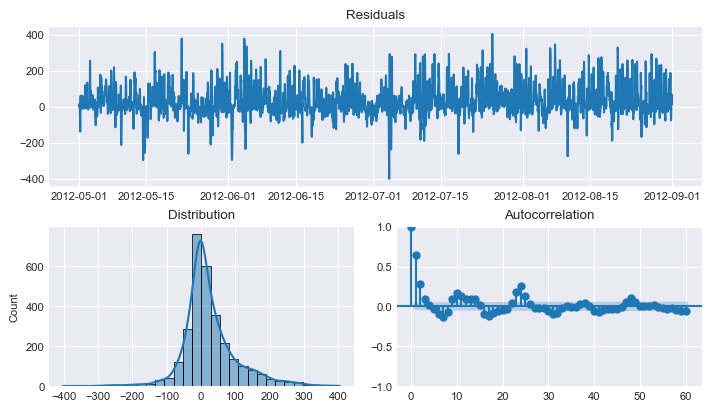

In [63]:
residuals = data.loc[predictions_val.index, 'users'] - predictions_val['pred']
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(
        y_true = data.loc[predictions_val.index, 'users'],
        y_pred = predictions_val['pred'],
        figsize=(7, 4)
    )

In [64]:
# Store out-sample residuals in the forecaster
forecaster.set_out_sample_residuals(
    y_true = data.loc[predictions_val.index, 'users'],
    y_pred = predictions_val['pred']
)

# Backtesting with prediction intervals in test data using out-sample residuals

In [65]:
cv = TimeSeriesFold(steps = 36, initial_train_size = len(data.loc[:end_validation]))
metric, predictions = backtesting_forecaster(
   forecaster              = forecaster,
   y                       = data['users'],
   exog                    = data[exog_features],
   cv                      = cv,
   metric                  = 'mean_absolute_error',
   interval                = [5, 95],  # 90% prediction interval
   interval_method         = 'conformal',
   use_in_sample_residuals = False,  # Use out-sample residuals
   use_binned_residuals    = True,   # Use residuals conditioned on predicted values
)
predictions.head(5)

  0%|          | 0/81 [00:00<?, ?it/s]

pred  lower_bound  upper_bound
2012-09-01 00:00:00  135.743517    70.071757   201.415277
2012-09-01 01:00:00  107.238810    41.567050   172.910570
2012-09-01 02:00:00   76.290757    39.126126   113.455388
2012-09-01 03:00:00   40.206164     3.041533    77.370796
2012-09-01 04:00:00   18.001776     7.046713    28.956840

In [66]:
fig = go.Figure([
    go.Scatter(name='Prediction', x=predictions.index, y=predictions['pred'], mode='lines'),
    go.Scatter(
        name='Real value', x=data_test.index, y=data_test['users'], mode='lines',
    ),
    go.Scatter(
        name='Upper Bound', x=predictions.index, y=predictions['upper_bound'], mode='lines',
        marker=dict(color="#444"), line=dict(width=0), showlegend=False
    ),
    go.Scatter(
        name='Lower Bound', x=predictions.index, y=predictions['lower_bound'], marker=dict(color="#444"),
        line=dict(width=0), mode='lines', fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False
    )
])
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="users",
    width=1600,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001),
    # Initial zoom on x axis betwee 1 oct to 10 oct
    xaxis=dict(range=['2012-10-01', '2012-10-10'])
)
fig.show()

# Predicted interval coverage (on test data)

In [67]:
coverage = calculate_coverage(
              y_true       = data.loc[end_validation:, "users"],
              lower_bound  = predictions["lower_bound"],
              upper_bound  = predictions["upper_bound"]
            )
area = (predictions['upper_bound'] - predictions['lower_bound']).sum()
print(f"Total area of the interval: {round(area, 2)}")
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

Total area of the interval: 550705.54
Predicted interval coverage: 86.6 %


# Model explanaibility

In [68]:
forecaster = ForecasterRecursive(
    regressor        = LGBMRegressor(**best_params),
    lags             = [1, 2, 3, 23, 24, 25, 167, 168, 169],
    window_features  = window_features,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)
forecaster.fit(
    y    = data.loc[:end_validation, 'users'],
    exog = data.loc[:end_validation, exog_features]
)

In [69]:
# Extract feature importance
# ==============================================================================
importance = forecaster.get_feature_importances()
importance.head(10)

feature  importance
0      lag_1        1012
8    lag_169         568
7    lag_168         556
1      lag_2         365
4     lag_24         358
6    lag_167         344
2      lag_3         325
3     lag_23         311
15  hour_sin         295
16  hour_cos         282

# Model Explainability with SHAP Values

**SHAP** (SHapley Additive exPlanations) values are a widely used technique for interpreting machine learning models. They provide a way to understand how each input feature — and each of its values — contributes to a prediction.

SHAP values offer both **visual** and **quantitative** insight, helping to explain model behavior and increase trust in the results.

### SHAP with Skforecast Models

It is possible to compute SHAP-based explanations for Skforecast models using just two components:

1. The **internal regressor** from the forecaster.
2. The **training matrices** (features and target) generated from the time series and used to fit the model.

By combining these two elements, users can generate rich, interpretable explanations for time series forecasts made with Skforecast.

### Why Use SHAP?

SHAP values can help:

- **Verify model reliability** by ensuring predictions are based on meaningful features.
- **Identify the most influential features** that contribute to each prediction.
- **Understand the relationship** between input variables and the forecasted target.
- **Communicate insights** to non-technical stakeholders in a transparent and intuitive way.

SHAP can be especially powerful when working with models like **LightGBM**, **CatBoost**, or **XGBoost**, which are commonly used inside Skforecast forecasters and natively supported by SHAP.



In [70]:
# Training matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                       y    = data.loc[:end_validation, 'users'],
                       exog = data.loc[:end_validation, exog_features]
                   )
display(X_train.head(3))
display(y_train.head(3))

lag_1  lag_2  lag_3  lag_23  lag_24  lag_25  lag_167  \
date_time                                                                   
2011-01-15 01:00:00   28.0   27.0   36.0     1.0     5.0    14.0     16.0   
2011-01-15 02:00:00   20.0   28.0   27.0     1.0     1.0     5.0      7.0   
2011-01-15 03:00:00   12.0   20.0   28.0     1.0     1.0     1.0      1.0   

                     lag_168  lag_169  roll_mean_72  ...  \
date_time                                            ...   
2011-01-15 01:00:00     16.0     25.0     55.736111  ...   
2011-01-15 02:00:00     16.0     16.0     55.930556  ...   
2011-01-15 03:00:00      7.0     16.0     56.083333  ...   

                    poly_hour_cos__sunrise_hour_sin  \
date_time                                             
2011-01-15 01:00:00                        0.933013   
2011-01-15 02:00:00                        0.836516   
2011-01-15 03:00:00                        0.683013   

                     poly_hour_cos__sunrise_hour_cos  \
date_time                                              
2011-01-15 01:00:00                        -0.250000   
2011-01-15 02:00:00                        -0.224144   
2011-01-15 03:00:00                        -0.183013   

                     poly_hour_cos__sunset_hour_sin  temp_window_1D_mean  \
date_time                                                                  
2011-01-15 01:00:00                       -0.933013             6.594167   
2011-01-15 02:00:00                       -0.836516             6.696667   
2011-01-15 03:00:00                       -0.683013             6.799167   

                     temp_window_1D_max  temp_window_1D_min  \
date_time                                                     
2011-01-15 01:00:00                9.84                 4.1   
2011-01-15 02:00:00                9.84                 4.1   
2011-01-15 03:00:00                9.84                 4.1   

                     temp_window_7D_mean  temp_window_7D_min  temp  holiday  
date_time                                                                    
2011-01-15 01:00:00             6.535595                3.28  6.56      0.0  
2011-01-15 02:00:00             6.530715                3.28  6.56      0.0  
2011-01-15 03:00:00             6.525833                3.28  6.56      0.0  

[3 rows x 60 columns]

date_time
2011-01-15 01:00:00    20.0
2011-01-15 02:00:00    12.0
2011-01-15 03:00:00     8.0
Freq: h, Name: y, dtype: float32

In [71]:
# Create SHAP explainer (for three base models)
# ==============================================================================
explainer = shap.TreeExplainer(forecaster.regressor)

# Sample 50% of the data to speed up the calculation

rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

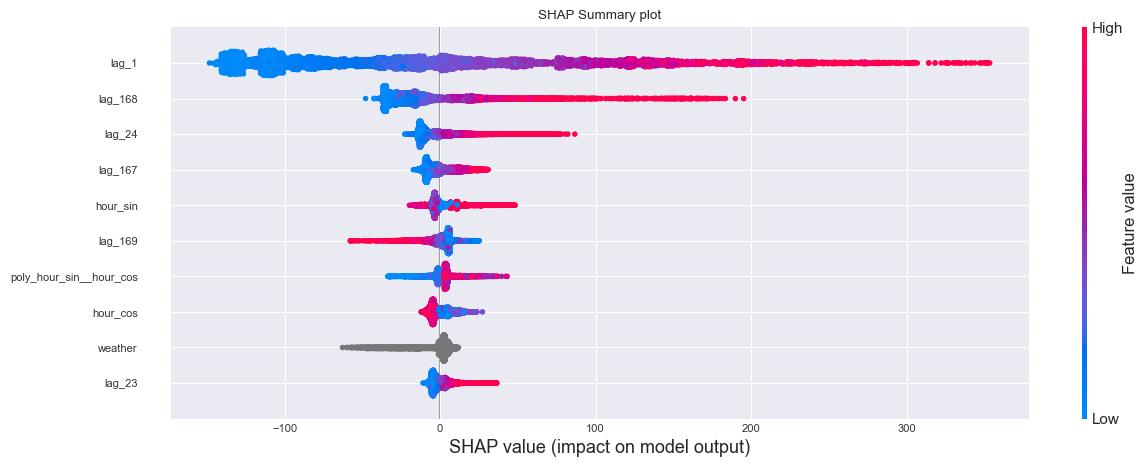

In [72]:
shap.initjs()
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(16, 4.5)

# XGBoost, CatBoost, HistGradientBoostingRegressor

In [73]:
cv_search = OneStepAheadFold(initial_train_size = len(data_train))
cv_backtesting = TimeSeriesFold(steps = 36, initial_train_size = len(data[:end_validation]))

# Xgboost

In [74]:
pipeline_categorical = make_pipeline(
    OrdinalEncoder(
        dtype=int,
        handle_unknown="use_encoded_value",
        unknown_value=-1,
        encoded_missing_value=-1
    ),
    FunctionTransformer(
        func=lambda x: x.astype('category'),
        feature_names_out= 'one-to-one'
    )
)

transformer_exog = make_column_transformer(
    (
        pipeline_categorical,
        make_column_selector(dtype_exclude=np.number)
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [75]:
forecaster = ForecasterRecursive(
    regressor = XGBRegressor(tree_method='hist', enable_categorical=True, random_state=123),
    lags = 24,
    window_features  = window_features,
    transformer_exog = transformer_exog
)

In [76]:
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 300, 1000, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'subsample'       : trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster   = forecaster,
    y            = data.loc[:end_validation, 'users'],
    exog         = data.loc[:end_validation, exog_features],
    cv           = cv_search,
    search_space = search_space,
    metric       = 'mean_absolute_error',
    n_trials     = 20
)

╭─────────────────────────── OneStepAheadValidationWarning ────────────────────────────╮
│ One-step-ahead predictions are used for faster model comparison, but they may not    │
│ fully represent multi-step prediction performance. It is recommended to backtest the │
│ final model for a more accurate multi-step performance estimate.                     │
│                                                                                      │
│ Category : OneStepAheadValidationWarning                                             │
│ Location :                                                                           │
│ /Users/pantost/Desktop/codehub/timeseries/timeseries_103/.venv/lib/python3.10/site-p │
│ ackages/skforecast/model_selection/_utils.py:675                                     │
│ Suppress : warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)   │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.012163256215940828, 'subsample': 0.7488435558350622, 'colsample_bytree': 0.9793122932942662, 'gamma': 0.9552902201381775, 'reg_alpha': 0.005831269672183059, 'reg_lambda': 0.2688363983494908}
  One-step-ahead metric: 39.16850280761719


In [77]:
metric_xgboost, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = data['users'],
    exog       = data[exog_features],
    cv         = cv_backtesting,
    metric     = 'mean_absolute_error'
)
metric_xgboost

  0%|          | 0/81 [00:00<?, ?it/s]

mean_absolute_error
0            52.509415

# HistGradientBoostingRegressor

In [78]:
categorical_features = ['weather']
transformer_exog = make_column_transformer(
    (
        OrdinalEncoder(
            dtype=int,
            handle_unknown="use_encoded_value",
            unknown_value=-1,
            encoded_missing_value=-1
        ),
        categorical_features
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [79]:
forecaster = ForecasterRecursive(
    regressor = HistGradientBoostingRegressor(
                    categorical_features=categorical_features,
                    random_state=123
                ),
    lags = 24,
    window_features = window_features,
    transformer_exog = transformer_exog
)

In [80]:
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

def search_space(trial):
    search_space  = {
        'max_iter'          : trial.suggest_int('max_iter', 300, 1000, step=100),
        'max_depth'         : trial.suggest_int('max_depth', 3, 10),
        'learning_rate'     : trial.suggest_float('learning_rate', 0.01, 1),
        'min_samples_leaf'  : trial.suggest_int('min_samples_leaf', 1, 20),
        'l2_regularization' : trial.suggest_float('l2_regularization', 0, 1),
        'lags'              : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster   = forecaster,
    y            = data.loc[:end_validation, 'users'],
    exog         = data.loc[:end_validation, exog_features],
    cv           = cv_search,
    search_space = search_space,
    metric       = 'mean_absolute_error',
    n_trials     = 20
)

╭─────────────────────────── OneStepAheadValidationWarning ────────────────────────────╮
│ One-step-ahead predictions are used for faster model comparison, but they may not    │
│ fully represent multi-step prediction performance. It is recommended to backtest the │
│ final model for a more accurate multi-step performance estimate.                     │
│                                                                                      │
│ Category : OneStepAheadValidationWarning                                             │
│ Location :                                                                           │
│ /Users/pantost/Desktop/codehub/timeseries/timeseries_103/.venv/lib/python3.10/site-p │
│ ackages/skforecast/model_selection/_utils.py:675                                     │
│ Suppress : warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)   │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'max_iter': 1000, 'max_depth': 10, 'learning_rate': 0.014839147189277493, 'min_samples_leaf': 19, 'l2_regularization': 0.015325290080303589}
  One-step-ahead metric: 40.20446907142766


In [81]:
metric_histgb, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = data['users'],
    exog       = data[exog_features],
    cv         = cv_backtesting,
    metric     = 'mean_absolute_error'
)
metric_histgb

  0%|          | 0/81 [00:00<?, ?it/s]

mean_absolute_error
0            46.617601

# CatBoost

In [82]:
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='if_binary'),
        make_column_selector(dtype_exclude=np.number),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Create forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
    regressor = CatBoostRegressor(
                    random_state=123, 
                    silent=True, 
                    allow_writing_files=False,
                    boosting_type = 'Plain',         # Faster training
                    leaf_estimation_iterations = 3,  # Faster training
                ),
    lags = 24,
    window_features = window_features,
    transformer_exog = one_hot_encoder
)

In [83]:
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 1),
        'lags'          : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster   = forecaster,
    y            = data.loc[:end_validation, 'users'],
    exog         = data.loc[:end_validation, exog_features],
    cv           = cv_search,
    search_space = search_space,
    metric       = 'mean_absolute_error',
    n_trials     = 20
)

╭─────────────────────────── OneStepAheadValidationWarning ────────────────────────────╮
│ One-step-ahead predictions are used for faster model comparison, but they may not    │
│ fully represent multi-step prediction performance. It is recommended to backtest the │
│ final model for a more accurate multi-step performance estimate.                     │
│                                                                                      │
│ Category : OneStepAheadValidationWarning                                             │
│ Location :                                                                           │
│ /Users/pantost/Desktop/codehub/timeseries/timeseries_103/.venv/lib/python3.10/site-p │
│ ackages/skforecast/model_selection/_utils.py:675                                     │
│ Suppress : warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)   │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.4365541356963474}
  One-step-ahead metric: 38.83545732277291


In [84]:
metric_catboost, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = data['users'],
    exog       = data[exog_features],
    cv         = cv_backtesting,
    metric     = 'mean_absolute_error'
)
metric_catboost

  0%|          | 0/81 [00:00<?, ?it/s]

mean_absolute_error
0            50.808368

In [85]:
metrics = pd.concat(
    [metric_baseline, metric_lgbm, metric_xgboost, metric_histgb, metric_catboost]
)
metrics.index = [
    "Baseline",
    "LGBMRegressor",
    "XGBRegressor",
    "HistGradientBoostingRegressor",
    "CatBoostRegressor",
]
metrics.round(2).sort_values(by="mean_absolute_error")

mean_absolute_error
HistGradientBoostingRegressor                46.62
LGBMRegressor                                46.75
CatBoostRegressor                            50.81
XGBRegressor                                 52.51
Baseline                                     91.67